# OpenAI Gym: simple environment

We start considering a simple OpenAI environment with a number of states that can be fitted in memory and exaustively explored. In this case we can use the standard Q-learning algorithm exploiting the temporal difference version of the Bellman equation:

$$Q({\small state}, {\small action}) \leftarrow (1 - \alpha) Q({\small state}, {\small action}) + \alpha \Big({\small reward} + \gamma \max_{a} Q({\small next \ state}, a)\Big)$$

where $\alpha$ is the learning rate and $\gamma$ the discount factor.

The `qlearn.py` file includes some support functions.

We'll use the [Taxi-v3](https://www.gymlibrary.ml/environments/toy_text/taxi/) environment.

In [1]:
import gym
import numpy as np

from qlearn import DiscreteQTable, plot_rewards, basic_training, run_episode

c:\Users\samue\anaconda3\envs\aima2021\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\samue\anaconda3\envs\aima2021\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\samue\anaconda3\envs\aima2021\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\samue\anaconda3\envs\aima2021\lib\site-packages\tensorf

First we create a new enviroment, we can use the `render` method to show the state:

In [10]:
gym_env = gym.make('Taxi-v3')

print('State: {}'.format(gym_env.s))
gym_env.render()

State: 132
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We can use a random agent to get the baseline for our work:

In [3]:
result = run_episode(gym_env, frames='ansi')

print('Random agent reward {} in {} steps'.format(result.reward, len(result.frames)))

Random agent reward -668 in 201 steps


Let's have a look at the actual episode

In [11]:
import time
from IPython import display

for frame in result.frames:
    display.clear_output(wait=True)
    print(frame)
    time.sleep(0.1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Instead of a single episode we look at the average over several ones:

Average reward: -779.23


<AxesSubplot:xlabel='Episode', ylabel='Total Reward'>

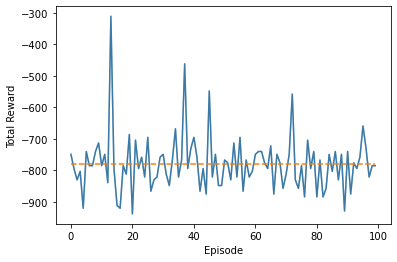

In [5]:
rewards = [run_episode(gym_env).reward for _ in range(100)]
print('Average reward: {}'.format(np.mean((rewards))))

plot_rewards(rewards)

To learn the Q-table we run several episodes by updating the table using the Bellman equation. We use the `basic_training` function defined in `qlearn.py`.

In [6]:
%psource basic_training

def basic_training(env: gym.Env, qtable: QTable, episodes: int,
    alpha=0.1, gamma=0.6,
    epsilon=0.1, epsilon_decay=0, epsilon_min=0.01,
    verbose: bool=False) -> Iterable[float]:
    rewards = []
    epsilon_c = epsilon

    for episode in range(episodes):
        obs = env.reset()
        ep_reward = 0
        random_count = 0
        while True:
            if epsilon_c > np.random.random():
                action = env.action_space.sample()
                random_count += 1
            else:
                action = qtable.policy(obs)

            new_obs, r, done, info = env.step(action)
            ep_reward += r

            exp_reward = (1 - alpha) * qtable.expected(obs, action) + alpha * (r + gamma * qtable.expected(new_obs))
            qtable.update(obs, action, exp_reward)

            obs = new_obs
            if done:
                if verbose:
                    print(f'Episode {episode}/episodes: reward {ep_reward}, random actions {random_count}, epsilon {epsil

Since the environment uses [gym.spaces.Discrete](https://www.gymlibrary.ml/content/spaces/#discrete) spaces for both observations and actions we can use a *Numpy* array to store the Q-table. You can look at the implementation of `DiscreteQTable`.

In [7]:
%psource DiscreteQTable

class DiscreteQTable(QTable):
    """QTable for discrete observation and action spaces."""
    def __init__(self, env: gym.Env, value: Union[float, Tuple[float, float]] = 0.0):
        obs_size = env.observation_space.n
        act_size = env.action_space.n
        if isinstance(value, (int, float)):
            self._table = np.full((obs_size, act_size), value)
        else:
            self._table = np.random.uniform(low=value[0], high=value[1], size=(obs_size, act_size))

    def update(self, obs: int, action: int, value: float) -> None:
        self._table[obs, action] = value

    def expected(self, obs: int, action: int = None) -> float:
        if action is None:
            return np.max(self._table[obs])
        else:
            return self._table[obs, action]

    def policy(self, obs):
        return np.argmax(self._table[obs])


Now we train our agent to learn the Q-table and have a look at rewards:

<AxesSubplot:xlabel='Episode', ylabel='Total Reward'>

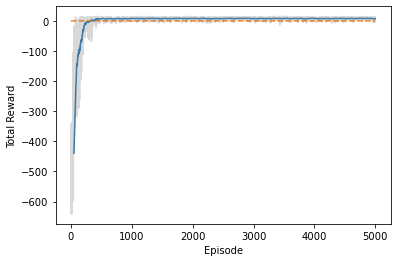

In [8]:
qtable = DiscreteQTable(gym_env)
plot_rewards(basic_training(gym_env, qtable, 5000, alpha=0.8, gamma=0.6, epsilon=0.4, epsilon_decay=0.01))


Let's see whether is better than before

Average reward: 7.64


<AxesSubplot:xlabel='Episode', ylabel='Total Reward'>

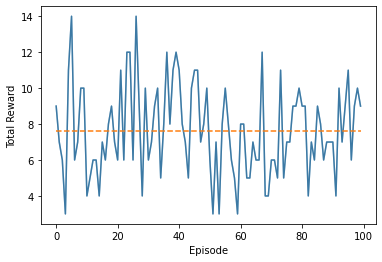

In [9]:
rewards = [run_episode(gym_env, qtable=qtable).reward for _ in range(100)]
print('Average reward: {}'.format(np.mean((rewards))))

plot_rewards(rewards)